In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, concat_ws, col
from pyspark.sql.types import *
import pyspark.sql.functions as F
import os
import numpy as np
import matplotlib.pyplot as plt

### Блок 1. Standalone Spark

In [2]:
spark = SparkSession.builder.master('spark://DESKTOP-5R90GJV.:7077').appName('spark-standalone-cluster').getOrCreate()

23/10/07 14:27:33 WARN Utils: Your hostname, DESKTOP-5R90GJV resolves to a loopback address: 127.0.1.1; using 172.21.181.17 instead (on interface eth0)
23/10/07 14:27:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/10/07 14:27:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
from datetime import datetime, date
import pandas as pd
from pyspark.sql import Row

df = spark.createDataFrame([
    Row(a=1, b=2., c='string1', d=date(2000, 1, 1), e=datetime(2000, 1, 1, 12, 0)),
    Row(a=2, b=3., c='string2', d=date(2000, 2, 1), e=datetime(2000, 1, 2, 12, 0)),
    Row(a=4, b=5., c='string3', d=date(2000, 3, 1), e=datetime(2000, 1, 3, 12, 0))
])

df.show()
df.printSchema()

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|
|  4|5.0|string3|2000-03-01|2000-01-03 12:00:00|
+---+---+-------+----------+-------------------+

root
 |-- a: long (nullable = true)
 |-- b: double (nullable = true)
 |-- c: string (nullable = true)
 |-- d: date (nullable = true)
 |-- e: timestamp (nullable = true)



Кажется все работает :)

### Блок 2. Работа с данными на Spark

In [4]:
path_books = './dataset_book/'
paths = os.listdir(path_books)

df = spark.read.csv(path_books + paths[0], header=True, inferSchema=True, escape='"', multiLine=True)

for path in paths[1:]:
    cur = spark.read.csv(path_books + path, header=True, inferSchema=True, escape='"', multiLine=True)
    df = df.unionByName(cur, allowMissingColumns=True)

In [5]:
print((len(df.columns), df.count()))

(20, 1850310)


In [6]:
df.printSchema()

root
 |-- PublishYear: integer (nullable = true)
 |-- Rating: double (nullable = true)
 |-- RatingDistTotal: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- RatingDist1: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- PublishMonth: integer (nullable = true)
 |-- Id: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Authors: string (nullable = true)
 |-- RatingDist5: string (nullable = true)
 |-- RatingDist4: string (nullable = true)
 |-- PublishDay: integer (nullable = true)
 |-- RatingDist2: string (nullable = true)
 |-- pagesNumber: integer (nullable = true)
 |-- RatingDist3: string (nullable = true)
 |-- CountsOfReview: integer (nullable = true)
 |-- Language: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Count of text reviews: integer (nullable = true)



In [7]:
df = df.withColumnRenamed("Count of text reviews", "Count_of_text_reviews")
df.printSchema()

root
 |-- PublishYear: integer (nullable = true)
 |-- Rating: double (nullable = true)
 |-- RatingDistTotal: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- RatingDist1: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- PublishMonth: integer (nullable = true)
 |-- Id: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Authors: string (nullable = true)
 |-- RatingDist5: string (nullable = true)
 |-- RatingDist4: string (nullable = true)
 |-- PublishDay: integer (nullable = true)
 |-- RatingDist2: string (nullable = true)
 |-- pagesNumber: integer (nullable = true)
 |-- RatingDist3: string (nullable = true)
 |-- CountsOfReview: integer (nullable = true)
 |-- Language: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Count_of_text_reviews: integer (nullable = true)



1) Оценить разницу в скорости чтения/занимаемом объеме для csv и parquet

In [8]:
#df.write.parquet("merged_data_parquet")
#df.write.csv('merged_data_csv', header=True)

In [9]:
def get_size(path):
    return sum(os.path.getsize(path + '/' + f) for f in os.listdir(path)) / 1024 / 1024

In [10]:
get_size('merged_data_parquet')

675.8351039886475

In [11]:
get_size('merged_data_csv')

1128.2334289550781

In [12]:
%%time
df_speed_test = spark.read.parquet("merged_data_parquet")

CPU times: user 2.51 ms, sys: 438 µs, total: 2.95 ms
Wall time: 517 ms


In [13]:
%%time
df_speed_test = spark.read.csv('merged_data_csv', header=True)

CPU times: user 2.94 ms, sys: 0 ns, total: 2.94 ms
Wall time: 615 ms


Видно, что parquet выирывает и по занимаемой памяти и по скорости чтения

2. Исследуем датасет

a) Топ 10 книг с наибольшим числом ревью

In [14]:
df.select('Name', 'CountsOfReview').orderBy('CountsOfReview', ascending=False).show(10)

+--------------------+--------------+
|                Name|CountsOfReview|
+--------------------+--------------+
|The Hunger Games ...|        154447|
|Twilight (Twiligh...|         94850|
|      The Book Thief|         87685|
|            The Help|         76040|
|Harry Potter and ...|         75911|
|The Giver (The Gi...|         57034|
| Water for Elephants|         52918|
|The Girl with the...|         52225|
|Harry Potter and ...|         52088|
|The Lightning Thi...|         48630|
+--------------------+--------------+
only showing top 10 rows



b) Топ-10 издателей с наибольшим средним числом страниц в книгах

In [15]:
df.select('Publisher', 'pagesNumber').groupBy('Publisher').avg('pagesNumber')\
.orderBy('avg(pagesNumber)', ascending=False).show(10)

+--------------------+------------------+
|           Publisher|  avg(pagesNumber)|
+--------------------+------------------+
|Crafty Secrets Pu...|         1807321.6|
|    Sacred-texts.com|          500000.0|
|Department of Rus...| 322128.5714285714|
|Logos Research Sy...|          100000.0|
|Encyclopedia Brit...|           32642.0|
|Progressive Manag...|        19106.3625|
|Still Waters Revi...|10080.142857142857|
|P. Shalom Publica...|            8539.0|
|Hendrickson Publi...|            6448.0|
|            IEEE/EMB|            6000.0|
+--------------------+------------------+
only showing top 10 rows



Цифры конечно немного странные...

c) Десять наиболее активных по числу изданных книг лет

In [16]:
df.select('PublishYear').groupBy('PublishYear').count().orderBy('count', ascending=False).show(10)

+-----------+------+
|PublishYear| count|
+-----------+------+
|       2007|129507|
|       2006|122374|
|       2005|117639|
|       2004|105733|
|       2003|104345|
|       2002| 95537|
|       2001| 88228|
|       2000| 87290|
|       2008| 80265|
|       1999| 80155|
+-----------+------+
only showing top 10 rows



d) Топ-10 книг имеющих наибольший разброс в оценках среди книг имеющих больше 500 оценок

In [17]:
df.select('Name', 'RatingDist1', 'RatingDist2', 'RatingDist3', 'RatingDist4', 'RatingDist5').show(10)

+--------------------+-----------+-----------+-----------+-----------+-----------+
|                Name|RatingDist1|RatingDist2|RatingDist3|RatingDist4|RatingDist5|
+--------------------+-----------+-----------+-----------+-----------+-----------+
|   The Gigli Concert|        1:2|        2:4|        3:8|       4:10|        5:3|
|The Oral History ...|        1:1|        2:8|       3:19|       4:28|       5:20|
|Negotiating Your ...|        1:0|        2:0|        3:0|        4:1|        5:1|
|John Gill: Master...|        1:2|        2:2|        3:5|        4:8|        5:1|
|Adobe Photoshop M...|        1:1|        2:0|        3:8|        4:7|       5:14|
|John Main: Essent...|        1:0|        2:1|        3:4|        4:9|        5:7|
|       The Deceivers|        1:3|       2:11|       3:46|      4:102|       5:74|
|Inside John Hayni...|        1:0|        2:0|        3:2|        4:3|        5:3|
|     Into the Tunnel|        1:0|        2:0|        3:2|        4:3|        5:0|
|Emp

В качестве разброса вроде логично взять среднеквадратичное отклонение оценки

In [18]:
def get_number(s):
    res = s.strip()
    return float(res.split(':')[1])

get_numer_udf = udf(get_number, FloatType())

In [19]:
df.withColumn('R1', get_numer_udf(df.RatingDist1))\
.withColumn('R2', get_numer_udf(df.RatingDist2))\
.withColumn('R3', get_numer_udf(df.RatingDist3))\
.withColumn('R4', get_numer_udf(df.RatingDist4))\
.withColumn('R5', get_numer_udf(df.RatingDist5))\
.withColumn('sum', col('R1') + col('R2') + col('R3') + col('R4') + col('R5'))\
.filter(col('sum') > 500)\
.withColumn('Ex', col('R1') + col('R2') * 2 + col('R3') * 3 + col('R4') * 4 + col('R5') * 5)\
.withColumn('Ex2', col('R1') + col('R2') * 4 + col('R3') * 9 + col('R4') * 16 + col('R5') * 25)\
.withColumn('var', col('Ex2') / col('sum') - (col('Ex') / col('sum')) ** 2)\
.withColumn('std', col('var') ** 0.5)\
.select('Name', 'std', 'sum')\
.orderBy('std', ascending=False)\
.show(10)

+--------------------+------------------+------+
|                Name|               std|   sum|
+--------------------+------------------+------+
|Scientology: The ...|1.6768910424786359| 853.0|
|Scientology: The ...|1.6754146863010673| 838.0|
|Para Entrenar a u...|1.6598983904363893|1656.0|
| To Train Up a Child|1.6595357900281973|1636.0|
|Para Entrenar a u...|1.6594892463426236|1634.0|
|The Bluebook: A U...| 1.588319793474554| 542.0|
|The Bluebook: A U...| 1.588319793474554| 542.0|
|Dianetics: The Mo...|1.5621103489386388|2897.0|
|Dianetics: The Mo...|1.5608955177100863|2869.0|
|Dianetica: La Cie...| 1.560357964963607|2860.0|
+--------------------+------------------+------+
only showing top 10 rows



Ого вот это конечно книги. Давайте чуть посмотрим что там еще есть

In [20]:
df.withColumn('R1', get_numer_udf(df.RatingDist1))\
.withColumn('R2', get_numer_udf(df.RatingDist2))\
.withColumn('R3', get_numer_udf(df.RatingDist3))\
.withColumn('R4', get_numer_udf(df.RatingDist4))\
.withColumn('R5', get_numer_udf(df.RatingDist5))\
.withColumn('sum', col('R1') + col('R2') + col('R3') + col('R4') + col('R5'))\
.filter(col('sum') > 500)\
.withColumn('Ex', col('R1') + col('R2') * 2 + col('R3') * 3 + col('R4') * 4 + col('R5') * 5)\
.withColumn('Ex2', col('R1') + col('R2') * 4 + col('R3') * 9 + col('R4') * 16 + col('R5') * 25)\
.withColumn('var', col('Ex2') / col('sum') - (col('Ex') / col('sum')) ** 2)\
.withColumn('std', col('var') ** 0.5)\
.select('Name')\
.orderBy('std', ascending=False)\
.show(100, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                Name|
+----------------------------------------------------------------------------------------------------+
|                                                            Scientology: The Fundamentals of Thought|
|                                                            Scientology: The Fundamentals of Thought|
|                                                        Para Entrenar a un Nino: To Train Up a Child|
|                                                                                 To Train Up a Child|
|                                                        Para Entrenar a un Nino: To Train Up a Child|
|                                                             The Bluebook: A Uniform System Citation|
|                                                          The Bluebook: 

О да, этот список стоял того, чтобы его получить)))

e) Средний рейтинг книг по годам за последние 10 лет, в оценках которых больше 500 ценок

In [21]:
df.withColumn('R1', get_numer_udf(df.RatingDist1))\
.withColumn('R2', get_numer_udf(df.RatingDist2))\
.withColumn('R3', get_numer_udf(df.RatingDist3))\
.withColumn('R4', get_numer_udf(df.RatingDist4))\
.withColumn('R5', get_numer_udf(df.RatingDist5))\
.withColumn('sum', col('R1') + col('R2') + col('R3') + col('R4') + col('R5'))\
.filter(col('sum') > 500)\
.withColumn('Ex', col('R1') + col('R2') * 2 + col('R3') * 3 + col('R4') * 4 + col('R5') * 5)\
.withColumn('avg_rating', col('Ex') / col('sum'))\
.select('PublishYear', 'avg_rating')\
.groupBy('PublishYear')\
.avg('avg_rating')\
.orderBy('PublishYear', ascending=False)\
.show(20)

+-----------+------------------+
|PublishYear|   avg(avg_rating)|
+-----------+------------------+
|      20040|3.7920540997464074|
|      20016|3.8582777248172864|
|      20015|3.9229126213592234|
|      19769| 3.834148329258354|
|       4989|3.9070072875790824|
|       3002|3.4226291693917594|
|       2994|4.2532236629431415|
|       2030| 4.216702663786897|
|       2020|4.0318459987808435|
|       2019|3.9354495471266846|
|       2018| 3.916732187171823|
|       2017| 3.940378668851767|
|       2016|  3.96829372110707|
|       2015| 4.001804888494612|
|       2014| 3.948047785149721|
|       2013|3.9315257993112276|
|       2012|3.9368876354668396|
|       2011|3.9364824342727434|
|       2010|3.9373034734945183|
|       2009|3.9187294784737987|
+-----------+------------------+
only showing top 20 rows



Интересно конечно получилось... Давайте удалим книги из будущего и далекого прошлого

In [22]:
df_ = df.filter((df.PublishYear < 2024) & (df.PublishYear > 1000))\
.withColumn('R1', get_numer_udf(df.RatingDist1))\
.withColumn('R2', get_numer_udf(df.RatingDist2))\
.withColumn('R3', get_numer_udf(df.RatingDist3))\
.withColumn('R4', get_numer_udf(df.RatingDist4))\
.withColumn('R5', get_numer_udf(df.RatingDist5))\
.withColumn('sum', col('R1') + col('R2') + col('R3') + col('R4') + col('R5'))\
.filter(col('sum') > 500)\
.withColumn('Ex', col('R1') + col('R2') * 2 + col('R3') * 3 + col('R4') * 4 + col('R5') * 5)\
.withColumn('avg_rating', col('Ex') / col('sum'))\
.select('PublishYear', 'avg_rating')\
.groupBy('PublishYear')\
.avg('avg_rating')\
.orderBy('PublishYear', ascending=False)

df_.show()

+-----------+------------------+
|PublishYear|   avg(avg_rating)|
+-----------+------------------+
|       2020|4.0318459987808435|
|       2019|3.9354495471266855|
|       2018|3.9167321871718226|
|       2017|3.9403786688517677|
|       2016|3.9682937211070706|
|       2015| 4.001804888494612|
|       2014| 3.948047785149721|
|       2013| 3.931525799311227|
|       2012| 3.936887635466839|
|       2011| 3.936482434272744|
|       2010| 3.937303473494517|
|       2009| 3.918729478473799|
|       2008| 3.906918928935481|
|       2007|3.9145583738949408|
|       2006|3.9253795995205394|
|       2005|3.9356767971475426|
|       2004|3.9326424163740086|
|       2003|3.9385770604360704|
|       2002|3.9390995313678197|
|       2001|3.9460258447969547|
+-----------+------------------+
only showing top 20 rows



In [23]:
rating = np.array(df_.select('avg(avg_rating)').collect())
years = np.array(df_.select('PublishYear').collect())

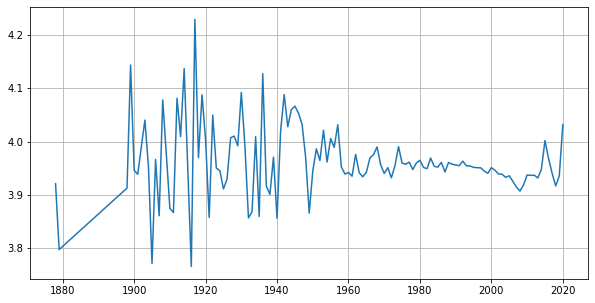

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(years, rating)
plt.grid()
plt.show()

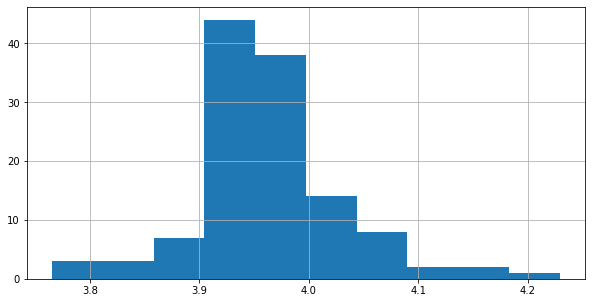

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(rating)
plt.grid()
plt.show()

С виду кажется, что средний рейтинг книг за год это просто случайная величина и от года не сильно зависит

### Блок 3. Spark Streaming

In [34]:
#for i in spark.streams.active:
#    i.stop()

In [35]:
schema = StructType().add("ID", "integer").add("Name", "string").add("Rating", "string")

stream = spark.readStream.format("csv").option("header", "true").option("quote", "\"")\
            .option("escape", "\"").schema(schema).csv("./dataset_rating/")

In [36]:
stream.groupBy('Rating').count().writeStream.format('console').outputMode('complete').start()

23/10/07 14:30:30 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-652bda23-21a1-4714-b00c-6503ce309c41. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+--------------------+------+
|              Rating| count|
+--------------------+------+
|     did not like it|  7811|
|     really liked it|132808|
|            liked it| 96047|
|           it was ok| 28811|
|      it was amazing| 92354|
|This user doesn't...|  4765|
+--------------------+------+



In [37]:
ratings = stream.select(col("ID"), 'Name', F.when(col("Rating") == 'did not like it', 1)\
                .when(col("Rating") == 'it was ok', 2)\
                .when(col("Rating") == 'liked it', 3)\
                .when(col("Rating") == 'really liked it', 4)\
                .when(col("Rating") == 'it was amazing', 5)\
                .when(col("Rating").startswith('This user doesn'), None)\
                .alias("Rating"))

In [38]:
avg_ratings = ratings.groupBy("Name")\
.agg(F.count('Rating').alias("CountRating"), (F.sum("Rating") / F.count("Rating")).alias("AvgRating") )

In [39]:
avg_ratings.writeStream \
    .format("memory") \
    .outputMode("update")\
    .queryName("my_table") \
    .start()

23/10/07 14:30:39 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-7cbb0fdd-437b-4179-bc06-d9d7ee4d5997. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


In [40]:
mem = spark.sql("SELECT * FROM my_table")
mem.orderBy('CountRating', ascending=False).show(20)

23/10/07 14:30:50 WARN TaskSetManager: Stage 82 contains a task of very large size (1137 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----------+------------------+
|                Name|CountRating|         AvgRating|
+--------------------+-----------+------------------+
|The Catcher in th...|        985| 3.986802030456853|
|    The Great Gatsby|        885|3.9559322033898305|
|The Da Vinci Code...|        846|3.1973995271867612|
|To Kill a Mocking...|        830|4.3180722891566266|
|                1984|        756| 4.144179894179894|
|     The Kite Runner|        749| 4.164218958611482|
|Harry Potter and ...|        728|3.9354395604395602|
|         Animal Farm|        717| 3.916317991631799|
|Harry Potter and ...|        639| 4.123630672926447|
|Harry Potter and ...|        631| 4.175911251980983|
|Harry Potter and ...|        595| 4.008403361344538|
|Harry Potter and ...|        593| 4.163575042158516|
| Pride and Prejudice|        580| 4.158620689655172|
| Memoirs of a Geisha|        574| 3.775261324041812|
|       The Alchemist|        556|3.3884892086330933|
|One Hundred Years...|      

In [41]:
mem.write.format("parquet").save("./user_rating/parquet")

23/10/07 14:30:55 WARN TaskSetManager: Stage 83 contains a task of very large size (1137 KiB). The maximum recommended task size is 1000 KiB.


Теперь проверим, что все работает

In [42]:
df_parquet = spark.read.parquet('./user_rating/parquet', header=True)

In [43]:
df_parquet.orderBy('CountRating', ascending=False).show(20)

+--------------------+-----------+------------------+
|                Name|CountRating|         AvgRating|
+--------------------+-----------+------------------+
|The Catcher in th...|        985| 3.986802030456853|
|    The Great Gatsby|        885|3.9559322033898305|
|The Da Vinci Code...|        846|3.1973995271867612|
|To Kill a Mocking...|        830|4.3180722891566266|
|                1984|        756| 4.144179894179894|
|     The Kite Runner|        749| 4.164218958611482|
|Harry Potter and ...|        728|3.9354395604395602|
|         Animal Farm|        717| 3.916317991631799|
|Harry Potter and ...|        639| 4.123630672926447|
|Harry Potter and ...|        631| 4.175911251980983|
|Harry Potter and ...|        595| 4.008403361344538|
|Harry Potter and ...|        593| 4.163575042158516|
| Pride and Prejudice|        580| 4.158620689655172|
| Memoirs of a Geisha|        574| 3.775261324041812|
|       The Alchemist|        556|3.3884892086330933|
|One Hundred Years...|      

P.s. Насколько я понял, формат данных parquet не поддерживает апдейт данных. Поэтому стрим я записал в память, а от туда уже в parquet. Насколько я понимаю, по хорошему нужно сохранять в формате Kafka, который как раз поддерживает апдейты. Но на установку и изучение кафки у меня не хватило времени и сил(